# Introduction to Machine Learning — 2023/2024 Reinforcement Learning



In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd


### Exercise 1

Build the simulation environment. Develop the following functionalities:

a) The state-transition function (s′ = f (s, a)), where a state (s) and an action (a) are given as argument, and a new state (the arrival state, s′) is returned, so that: f(1,right) = 2, f(1, down) = 11, f(1, up) = 1, etc.

When tie, than always chose random action

In [179]:
def stateTransitionFunction(state, action):
    newstate = state
    if action == 'right':
        newstate += 1
    elif action == 'left':
        newstate -= 1
    elif action == 'up':
        newstate -= 10
    elif action == 'down':
        newstate += 10
    
    if newstate in range(1, 101):
        if not (state % 10 == 1 and action == 'left') and not (state % 10 == 0 and action == 'right'):
            state = newstate

    return state

In [180]:
stateTransitionFunction(1, "left")

1

b) A reward function r(s) that rewards all states with 0 and the goal-state(state100) with 100 points.

In [181]:
def getReward(state):
    reward = 0
    if state == 100:
        reward = 100
    else:
        pass

    return (reward)

In [182]:
getReward(10000)

0

c) A function that randomly chooses an action.

In [183]:
def randomlyChoseAction():
    possibleActions = ["up", "left", "right", "down"]
    randomPosition = random.randint(0,3)
    randomAction = possibleActions[randomPosition]

    return (randomAction)


In [184]:
randomlyChoseAction()

'right'

d)  An episode consists in all the movements from the start-point until it reaches the goal, or until it gives-up (because it has reached the maximum number of steps allowed). Define the end of the episode as: the robot reaches the goal-state (the plug, marked with an X, state 100) or the robot performs 1000 actions without reaching the goal. After the end of an episode the robot gets the reward (if it has reached the goal) and is always returned to the initial position. 

In [185]:
def runEpisode(state = 1, finalState = 100, maxNumberStepsAllowed = 1000):
    numberOfStepsEpisode = 0
    reward = 0

    while state != finalState and numberOfStepsEpisode < maxNumberStepsAllowed:
        state = stateTransitionFunction(state, randomlyChoseAction())
        reward += getReward(state) 
        numberOfStepsEpisode +=1

    return (numberOfStepsEpisode, reward)

random.seed(13)
print(runEpisode())


(743, 100)


e) Simulate the robot performing an episode and repeat it 30 times. Measure and record the average reward per step in each episode and the number of steps to reach the goal in each episode. Calculate the mean and standard deviation of the number of steps to reach the goal, execution times, and rewards for the 30 tests. These will be the reference results and will be used to test whether the system is performing better than just guessing randomly.


In [186]:
allNumberOfStepsEpisode = []
allRewards = [] # need???
allexecutionTimes = []
allRewardsPerSteps = []

random.seed(13)
for i in range(30):
    startTime = time.time()
    numberOfStepsEpisode, reward = runEpisode()
    endTime = time.time()
    executionTime = endTime - startTime

    allNumberOfStepsEpisode.append(numberOfStepsEpisode)
    allRewards.append(reward)
    allexecutionTimes.append(executionTime)

    rewardPerStep = reward/numberOfStepsEpisode
    allRewardsPerSteps.append(rewardPerStep)


# get metrics

# steps needed
meanNumberOfStepsEpisode = sum(allNumberOfStepsEpisode) /len(allNumberOfStepsEpisode)
sdNumberOfStepsEpisode = np.std(allNumberOfStepsEpisode)
print(f"number of steps mean: {meanNumberOfStepsEpisode}, sd: {sdNumberOfStepsEpisode}")

# reward total
meanRewards = sum(allRewards) /len(allRewards)
sdRewards = np.std(allRewards)
print(f"overall reward mean: {meanRewards}, sd: {sdRewards}")

# execution time
meanExecutionTimes = sum(allexecutionTimes) /len(allexecutionTimes)
sdExecutionTimes = np.std(allexecutionTimes)
print(f"execution time mean: {meanExecutionTimes}, sd: {sdExecutionTimes}")

# average reward per step
averageRewardPerStep = sum(allRewardsPerSteps) /len(allRewardsPerSteps)
sdRewardPerStep = np.std(allRewardsPerSteps)
print(f"average rewards per step: {averageRewardPerStep}, sd: {sdRewardPerStep}")


number of steps mean: 588.4666666666667, sd: 311.68442730143295
overall reward mean: 73.33333333333333, sd: 44.221663871405326
execution time mean: 0.0010157426198323567, sd: 0.0006343827745723731
average rewards per step: 0.22732994299646986, sd: 0.21027542407602043



f) Represent the mean and standard deviation (reward, steps to reach the goal, and execution times), each in a different boxplot with vertical boxes (Figure 2).

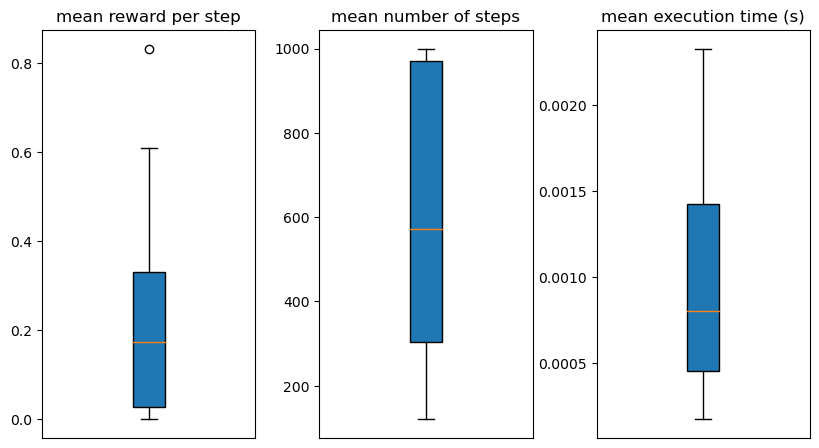

In [187]:
# visualize metrics
fig, axs = plt.subplots(1, 3)

axs[0].boxplot(allRewardsPerSteps, 
                   patch_artist=True)
axs[0].set_title("mean reward per step")
axs[0].set_xticks([])

axs[1].boxplot(allNumberOfStepsEpisode, 
                   patch_artist=True)
axs[1].set_title("mean number of steps")
axs[1].set_xticks([])

axs[2].boxplot(allexecutionTimes, 
                   patch_artist=True)
axs[2].set_title("mean execution time (s)")
axs[2].set_xticks([])

fig.subplots_adjust(left=0.2, right=1.4, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)


plt.show()

# Exercise 2

Create a matrix Q

In [188]:
dType = [('right', 'f4'), ('left', 'f4'), ('up', 'f4'), ('down', 'f4')]
matrixQ = np.zeros(101, dtype = dType)
#matrixQ["right"]

In [189]:
def getUpdatedUtility(state, action, matrixQ, alpha = 0.7, discountRate = 0.99):
    QAtStateAndAction = matrixQ[action][state]
    nextState = stateTransitionFunction(state, action)
    rewardAtNextState = getReward(nextState)

    allPossibleUtilitiesAtNextState = [matrixQ["right"][nextState], matrixQ["left"][nextState], matrixQ["up"][nextState], matrixQ["down"][nextState]]
    # randomly shuffle list with values to pick randomly when encountering ties
    random.shuffle(allPossibleUtilitiesAtNextState)
    maxUtilityNextState = max(allPossibleUtilitiesAtNextState)

    utilityState = (1-alpha)*QAtStateAndAction + alpha * (rewardAtNextState + discountRate*maxUtilityNextState)
    return (utilityState)

def updateUtility(state, action, matrixQ, alpha = 0.7, discountRate = 0.99):
    updatedUtility = getUpdatedUtility(state, action, matrixQ, alpha, discountRate)
    matrixQ[action][state] = updatedUtility

    return (matrixQ)


a) Do a random walk (like in Exercise 1) and execute this update-function after each state transition for 20000 steps in each experiment. Repeat the experiment 30 times. In each of the 30 experiments, at steps 100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, and 20000 (or other intermediate points that are deemed useful) stop to run a test.

A test consists of running the system for 1000 steps using the current Q table (without changing it) and always choosing the best action at each step. Measure the average reward per step in these 1000 steps.

Measure also the runtime of each full test (all 20000 steps) and calculate average and standard-deviation of run-times for the tests. 

Plot the steps (x-axis) vs the average reward (y-axis) of the tests at the measured points. A series of box plots can also be used for a more informative view of the evolution of the robot’s behaviour.

Depict the final utility of each state (the quality of the best action for each state), rep- resenting what the agent learned about the environment, using a heatmap (Figure 3).


In [ ]:
def getNextBestStep(state, matrixQ):
    allPossibleUtilitiesAtThisState = {"right": matrixQ["right"][state], 
                                       "left": matrixQ["left"][state], 
                                       "up": matrixQ["up"][state], 
                                       "down": matrixQ["down"][state]}
    dictInShuffleProcess = list(allPossibleUtilitiesAtThisState.items())
    random.shuffle(dictInShuffleProcess)
    allPossibleUtilitiesAtThisState = dict(dictInShuffleProcess)
    maxUtilityNextState = max(allPossibleUtilitiesAtThisState, key = allPossibleUtilitiesAtThisState.get)
    return (maxUtilityNextState)


def runTest(state, matrixQ, howManySteps = 1000):
    rewardOverall = 0
    for i in range(howManySteps):
        action = getNextBestStep(state, matrixQ)
        state = stateTransitionFunction(state, action)
        rewardOverall += getReward(state)
    averageRewardPerStep = rewardOverall/howManySteps
    return (averageRewardPerStep)
    

def runEpisodeWithUpdatingUtilities(matrixQ = matrixQ, state = 1, finalState = 100, maxNumberSteps = 20000, alwaysBestSep = False):
    copyMatrixQ = matrixQ.copy()
    listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]
    count = 0
    allAverageRewardsPerStep = []
    for i in range(maxNumberSteps+1):
        if alwaysBestSep == True:
            action = getNextBestStep(state, copyMatrixQ)
        else:
            action = randomlyChoseAction()
        newState = stateTransitionFunction(state, action)
        copyMatrixQ = updateUtility(state = state, action = action, matrixQ = copyMatrixQ)
        state = newState
        if count in listWithPointsWhereTorRunTests:
            allAverageRewardsPerStep.append(runTest(state = state, matrixQ = copyMatrixQ, howManySteps = 1000))
        count += 1 
    return (allAverageRewardsPerStep, copyMatrixQ)


allAverageRewardsPerStep, copyMatrixQ = runEpisodeWithUpdatingUtilities()

In [201]:
allexecutionTimes = []
allAllAverageRewardsPerStep = np.zeros((30, 16))


random.seed(17)
for i in range(30):
    startTime = time.time()
    allAverageRewardsPerStep, MatrixQEndExploration = runEpisodeWithUpdatingUtilities()
    endTime = time.time()
    executionTime = endTime - startTime

    allAllAverageRewardsPerStep[i] = allAverageRewardsPerStep

    
    allexecutionTimes.append(executionTime)



# execution time
meanExecutionTimes = sum(allexecutionTimes) /len(allexecutionTimes)
sdExecutionTimes = np.std(allexecutionTimes)
print(f"execution time mean: {meanExecutionTimes}, sd: {sdExecutionTimes}")


# average rewards per step for the 16 steps
averageRewardMeansRandom = np.mean(allAllAverageRewardsPerStep, axis=0)


execution time mean: 0.29836382865905764, sd: 0.003312054330959817


In [236]:
def showHeatmap(matrixQ):

    directions = ['right', 'left', 'up', 'down']

    arrayForHeatMap = np.zeros(101)
    directionsWithHighestUtility = np.zeros(101, dtype=int)
    for count, row in enumerate(matrixQ):
        utilities = np.array([row['right'], row['left'], row['up'], row['down']])
        maxIndex = np.argmax(utilities)
        arrayForHeatMap[count] = utilities[maxIndex]
        directionsWithHighestUtility[count] = maxIndex
    arrayForHeatMap = np.delete(arrayForHeatMap, obj=0)

    arrayForHeatMap = arrayForHeatMap.reshape((10, 10))

    fig, ax = plt.subplots(figsize=(8, 8))
    heatmap = ax.imshow(arrayForHeatMap, cmap='hot')
    fig.colorbar(heatmap)

    arrowOffset = 0.2

    for i in range(10):
        for j in range(10):
            index = i * 10 + j
            direction = directions[directionsWithHighestUtility[index]]
            
            # Coordinates for placing arrows in each cell
            x = j
            y = i

            # Draw arrows based on the highest direction
            if direction == 'right':
                ax.arrow(x, y, arrowOffset, 0, head_width=0.05, head_length=0.1, fc='white', ec='white')
            elif direction == 'left':
                ax.arrow(x, y, arrowOffset, 0, head_width=0.05, head_length=0.1, fc='white', ec='white')
            elif direction == 'up':
                ax.arrow(x, y, 0, arrowOffset, head_width=0.05, head_length=0.1, fc='white', ec='white')
            elif direction == 'down':
                ax.arrow(x, y, 0, arrowOffset, head_width=0.05, head_length=0.1, fc='white', ec='white')

    plt.title('Heatmap of Highest Utility Directions')
    plt.show()

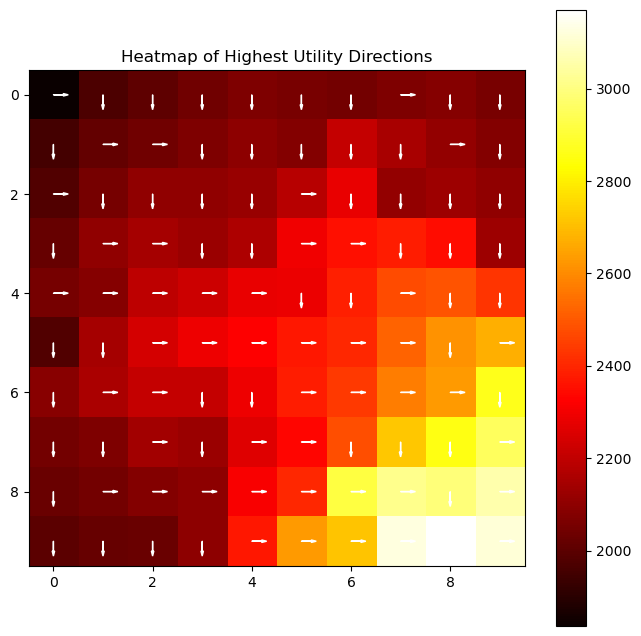

In [237]:
showHeatmap(MatrixQEndExploration)

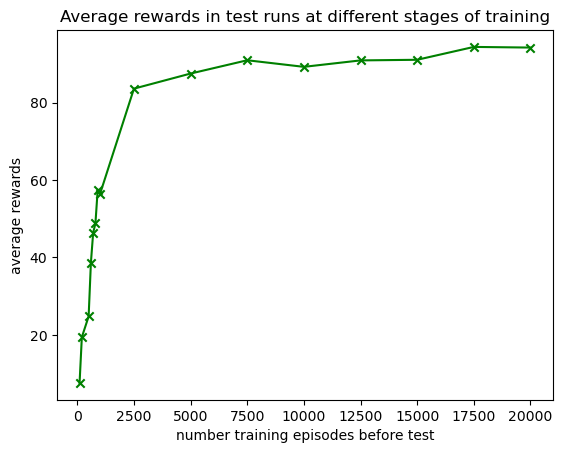

In [192]:
# visualize average reward 
listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansRandom, c="green", label = "random steps")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansRandom, c='green', marker='x')

plt.title('Average rewards in test runs at different stages of training')
plt.xlabel("number training episodes before test")
plt.ylabel("average rewards")
plt.show()

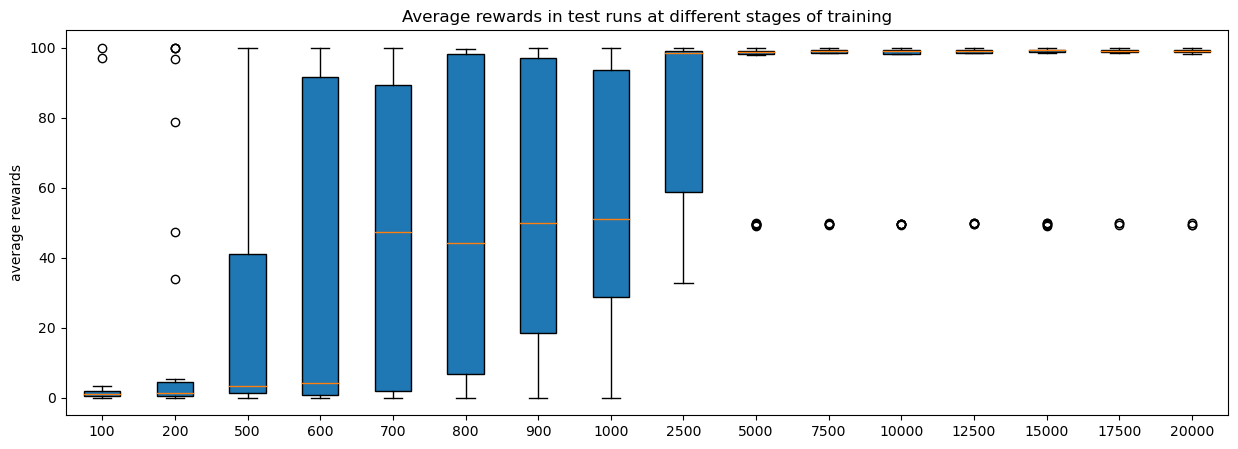

In [193]:
# show average rewards in boxplots
def showBoxplot(values, labels):

    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_ylabel("average rewards")
    ax.set_title('Average rewards in test runs at different stages of training')
    bplot = ax.boxplot(values, 
                    labels = labels, 
                    patch_artist=True,
                    whis=1.5)

    plt.show()

showBoxplot(values = allAllAverageRewardsPerStep, labels = listWithPointsWhereTorRunTests)

b) Do the same test as the previous example, but instead of a random walk use always the Q-table values to choose the best action. Be careful to break ties randomly.

In [241]:
allexecutionTimesExploitation = []
allAllAverageRewardsPerStepExploitation = np.zeros((30, 16))


random.seed(10)
for i in range(30):
    startTime = time.time()
    allAverageRewardsPerStep, copyMatrixQExploitation = runEpisodeWithUpdatingUtilities(alwaysBestSep = True)
    endTime = time.time()
    executionTime = endTime - startTime

    allAllAverageRewardsPerStepExploitation[i] = allAverageRewardsPerStep

    
    allexecutionTimesExploitation.append(executionTime)



# execution time
meanExecutionTimesExploitation = sum(allexecutionTimesExploitation) /len(allexecutionTimesExploitation)
sdExecutionTimesExploitation = np.std(allexecutionTimesExploitation)
print(f"execution time mean: {meanExecutionTimesExploitation}, sd: {sdExecutionTimesExploitation}")


# average rewards per step for the 16 steps
averageRewardMeansAlwaysBest = np.mean(allAllAverageRewardsPerStepExploitation, axis=0)


execution time mean: 0.3832307100296021, sd: 0.030503950902447136


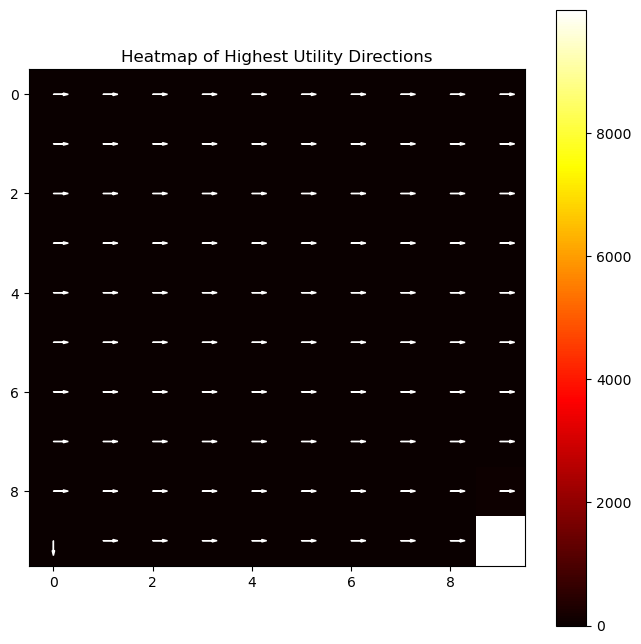

In [242]:
showHeatmap(copyMatrixQExploitation)

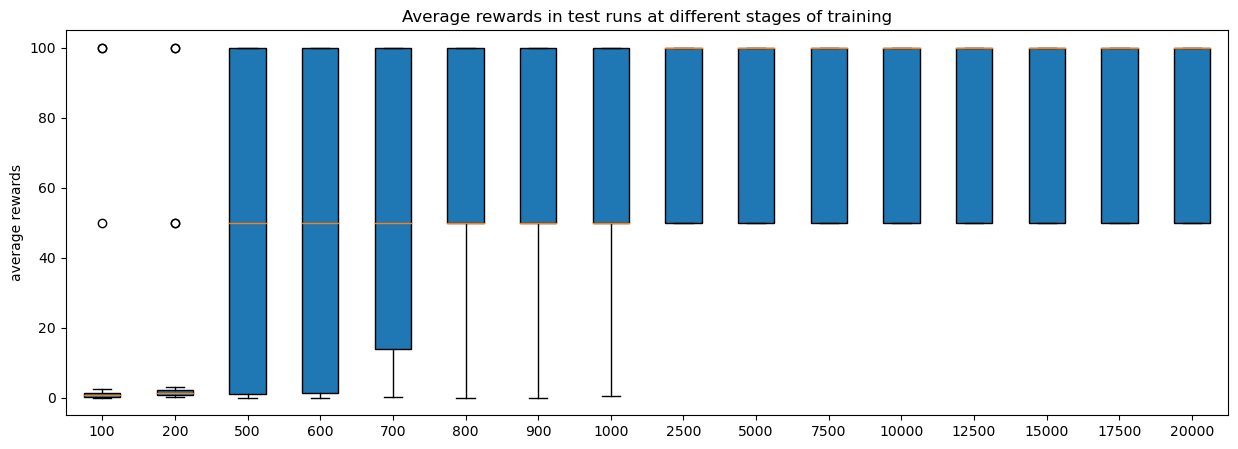

In [243]:
showBoxplot(values = allAllAverageRewardsPerStepExploitation, labels = listWithPointsWhereTorRunTests)

In [197]:
random.seed(17)
averageRewardMeansAlwaysBest, matrixQend = runEpisodeWithUpdatingUtilities(alwaysBestSep = True)

random.seed(13)
averageRewardMeansAlwaysBestSecondPossibility, matrixQend = runEpisodeWithUpdatingUtilities(alwaysBestSep = True)

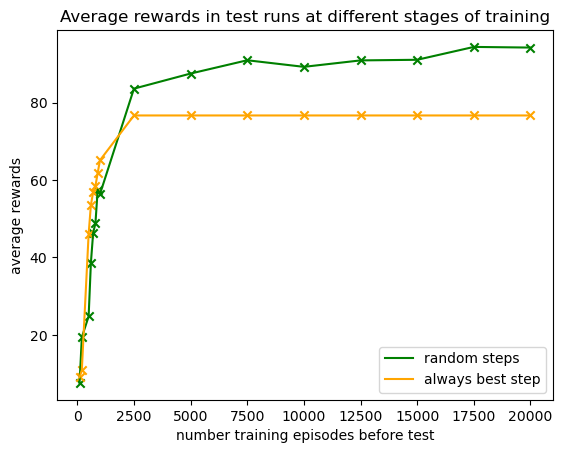

In [244]:
# visualize average reward 
listWithPointsWhereTorRunTests = [100, 200, 500, 600, 700, 800, 900, 1000, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000]

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansRandom, c="green", label = "random steps")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansRandom,c='green', marker='x')

plt.plot(listWithPointsWhereTorRunTests, averageRewardMeansAlwaysBest, c="orange", label = "always best step")
plt.scatter(listWithPointsWhereTorRunTests, averageRewardMeansAlwaysBest, c="orange", marker='x')

plt.title('Average rewards in test runs at different stages of training')
plt.xlabel("number training episodes before test")
plt.ylabel("average rewards")
plt.legend()
plt.show()

### Can you tell the best action from any given state? Compare tests a) and b) and draw your conclusions.

If we always chose the best next step, we will reach better performance (i.e. higher rewards) more quickly. But therefore it can happen (unluckily initial path) that the rewards that the agents get stagnate and do not reach as high values as with the technique to explore in a (see graph in red). The explore path gets higher rewards slower but consistently gets better.

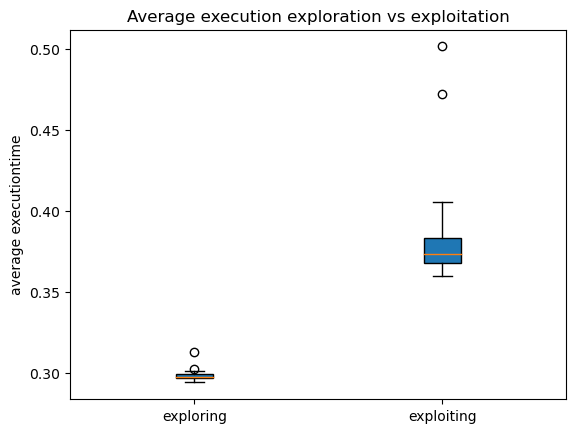

In [245]:
# compare execution time

times = [allexecutionTimes, allexecutionTimesExploitation]
labelNames = ["exploring", "exploiting"]

fig, ax = plt.subplots()
ax.set_ylabel("average executiontime")
ax.set_title('Average execution exploration vs exploitation')
bplot = ax.boxplot(times, 
                   labels = labelNames, 
                   patch_artist=True,
                   whis=1.5)

plt.show()


### Exercise 3
